In [1]:
from utils import *
%matplotlib inline

# Predict with a pre-trained model
<br>
<center><img src="support/predict.gif" width=600></center>

A saved model can be used in multiple places, such as to continue training, to fine tune the model, and for prediction. In this tutorial we will discuss how to predict new examples using a pretrained model.

## Prerequisites

Please run the [previous tutorial](train.md) to train the network and save its parameters to file. You will need this file to run the following steps.

In [2]:
from mxnet import nd, gluon

import matplotlib.pyplot as plt
from mxnet.gluon import nn
from mxnet.gluon.data.vision import datasets, transforms

To start, we will copy a simple model's definition.

## Build the model

In [3]:
net = nn.Sequential()
with net.name_scope():
    net.add(
        nn.Conv2D(channels=6, kernel_size=5, activation='relu'),
        nn.MaxPool2D(pool_size=2, strides=2),
        nn.Conv2D(channels=16, kernel_size=3, activation='relu'),
        nn.MaxPool2D(pool_size=2, strides=2),
        nn.Flatten(),
        nn.Dense(120, activation="relu"),
        nn.Dense(84, activation="relu"),
        nn.Dense(10)
    )

In the last section, we saved all parameters into a file, now let's load it back.

## Load the parameters

In [4]:
net.load_parameters('net.params')

## Predict

Remember the data transformation we did for training? Now we need the same transformation for predicting.

Common to normalize each image by the mean channel value and standard deviation.

In [5]:
transformer = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.13, 0.31)])

Now let's try to predict the first six images in the validation dataset and store the predictions into `preds`.

Predict 6 first images

In [6]:
mnist_valid = datasets.FashionMNIST(train=False)
X, y = mnist_valid[:6]

Run through network

In [7]:
preds = []  
for x in X:
    x = transformer(x).expand_dims(axis=0)
    pred = net(x).softmax().argmax(axis=1)
    preds.append(pred.astype('int32').asscalar())

In [8]:
def plot_images(X, y, preds):
    _, figs = plt.subplots(1, 6, figsize=(15, 15))
    text_labels = [
        't-shirt', 'trouser', 'pullover', 'dress', 'coat',
        'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot'
    ]
    for f,x,yi,pyi in zip(figs, X, y, preds):
        f.imshow(x.reshape((28,28)).asnumpy())
        ax = f.axes
        ax.set_title(text_labels[yi]+'\n'+text_labels[pyi])
        ax.title.set_fontsize(20)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()
    plt.close()

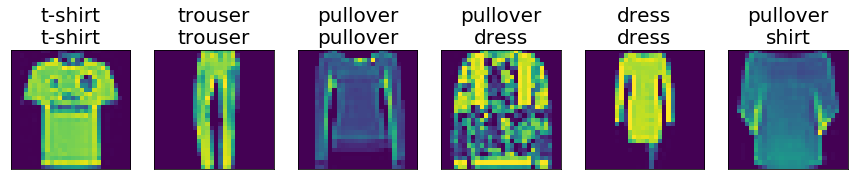

In [9]:
plot_images(X, y, preds)

Finally, we visualize the images and compare the prediction with the ground truth.

## Predict with models from Gluon model zoo

The LeNet trained on FashionMNIST is a good example to start with, but too simple to predict real-life pictures. Instead of training large-scale model from scratch, [Gluon model zoo](https://mxnet.incubator.apache.org/api/python/gluon/model_zoo.html) provides multiple pre-trained powerful models. For example, we can download and load a pre-trained ResNet-50 V2 model that was trained on the ImageNet dataset.

In [10]:
from mxnet.gluon.model_zoo import vision as models
from mxnet.gluon.utils import download
from mxnet import image

In [11]:
net = models.resnet50_v2(pretrained=True)

We also download and load the text labels for each class.

In [12]:
url = 'http://data.mxnet.io/models/imagenet/synset.txt'
fname = download(url)
with open(fname, 'r') as f:
    text_labels = [' '.join(l.split()[1:]) for l in f]
    
print(*text_labels[:10], sep='\n')

tench, Tinca tinca
goldfish, Carassius auratus
great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias
tiger shark, Galeocerdo cuvieri
hammerhead, hammerhead shark
electric ray, crampfish, numbfish, torpedo
stingray
cock
hen
ostrich, Struthio camelus


We randomly pick a dog image from Wikipedia as a test image, download and read it.

In [13]:
url = 'https://upload.wikimedia.org/wikipedia/commons/thumb/b/b5/Golden_Retriever_medium-to-light-coat.jpg/365px-Golden_Retriever_medium-to-light-coat.jpg'

support/lab.jpg


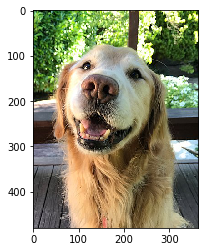

In [14]:
fname = download(url, path="support/lab.jpg")
print(fname)
plt.imshow(plt.imread(fname))

### Preprocessing

1. Resize the short edge into 256 pixes,
2. Perform a center crop to obtain a 224-by-224 image.

Following the conventional way of preprocessing ImageNet data:

1. Resize the short edge into 256 pixes,
2. And then perform a center crop to obtain a 224-by-224 image.

The following code uses the image processing functions provided in the MXNet [image module](https://mxnet.incubator.apache.org/api/python/image/image.html).

In [15]:
x = image.imread(fname)
x.shape

(480, 365, 3)

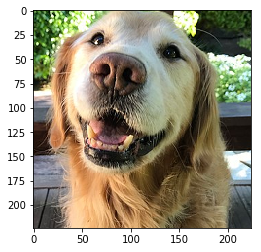

In [16]:
x = image.resize_short(x, 256)
x, _ = image.center_crop(x, (224,224))

plt.imshow(x.asnumpy())
plt.show()

Now you may know it is a golden retriever (You can also infer it from the image URL).

The futher data transformation is similar to FashionMNIST except that we subtract the RGB means and divide by the corresponding variances to normalize each color channel.

In [17]:
def transform(data):
    data = data.transpose((2,0,1)).expand_dims(axis=0)
    rgb_mean = nd.array([0.485, 0.456, 0.406]).reshape((1,3,1,1))
    rgb_std = nd.array([0.229, 0.224, 0.225]).reshape((1,3,1,1))
    return (data.astype('float32') / 255. - rgb_mean) / rgb_std

Now we can recognize the object in the image now. We perform an additional softmax on the output to obtain probability scores. And then print the top-5 recognized objects.

In [18]:
output = net(transform(x))

pred = output.softmax()

In [19]:
idx = pred.topk(k=5).squeeze()
for i in idx:
    i = int(i.asscalar())
    print('With prob = %.5f, it contains %s' % (
        pred[0,i].asscalar(), text_labels[i]))

With prob = 0.98323, it contains golden retriever
With prob = 0.00729, it contains English setter
With prob = 0.00297, it contains Irish setter, red setter
With prob = 0.00224, it contains cocker spaniel, English cocker spaniel, cocker
With prob = 0.00147, it contains Labrador retriever


As can be seen, the model is fairly confident the image contains a golden retriever.